In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## get sessions with pfc or mec

In [3]:
# from ripple_heterogeneity.readout import readout_explained_var

# df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
# cell_metrics = loading.load_all_cell_metrics(df.basepath)

# sessions = pd.DataFrame()
# sessions["basepath"] = cell_metrics[
#     cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
# ].basepath.unique()

# load data

In [19]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr"
)

ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)

pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)

pairwise_corr_df.loc[pairwise_corr_df.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"
pairwise_corr_df = pairwise_corr_df[~np.isnan(pairwise_corr_df['corrcoef'])]
pairwise_corr_df.reset_index(drop=True, inplace=True)

In [20]:
pairwise_corr_df

,epoch,region,sublayer,basepath,corrcoef
0,pre,MEC,Deep,Z:\Data\AYAold\AYA7\day19,0.071743
1,pre,MEC,Deep,Z:\Data\AYAold\AYA7\day19,0.026452
2,pre,MEC,Deep,Z:\Data\AYAold\AYA7\day19,0.049039
3,pre,MEC,Deep,Z:\Data\AYAold\AYA7\day19,0.005640
4,pre,MEC,Deep,Z:\Data\AYAold\AYA7\day19,0.113637
...,...,...,...,...,...
469992,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,0.228201
469993,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,0.030981
469994,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,0.090695
469995,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,0.217487


In [21]:
pairwise_corr_df["region_sublayer"] = pairwise_corr_df["sublayer"] + "_" + pairwise_corr_df["region"]

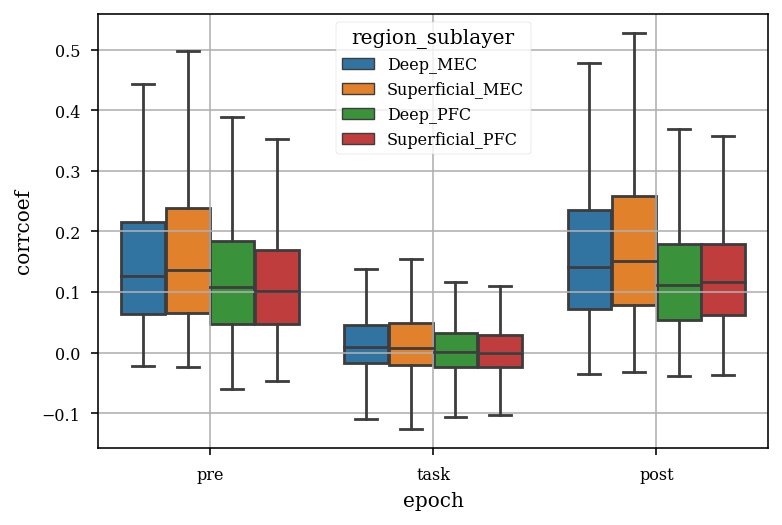

In [22]:
sns.boxplot(x="epoch", y="corrcoef",hue="region_sublayer", data=pairwise_corr_df, showfliers=False)
# sns.stripplot(x="epoch", y="corrcoef",hue="region_sublayer", data=pairwise_corr_df,dodge=True,color='k',alpha=.2)
plt.grid()

In [25]:
for basepath in pairwise_corr_df.basepath.unique():
    session_idx = pairwise_corr_df.basepath == basepath
    for epoch in pairwise_corr_df[session_idx].epoch.unique():
        epoch_idx = (pairwise_corr_df.epoch == epoch) & (pairwise_corr_df.basepath == basepath)
        pairwise_corr_df.loc[epoch_idx, "session_idx"] = np.arange(sum(epoch_idx))

In [74]:
pairwise_corr_df["r2"] = pairwise_corr_df["corrcoef"] ** 2

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=3.473e-49 stat=1.487e+01
MEC_Deep v.s. MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.465e-12 stat=-7.323e+00
MEC_Superficial v.s. PFC_Deep: t-test independent samples with Bonferroni correction, P_val=7.729e-285 stat=3.626e+01
MEC_Deep v.s. PFC_Deep: t-test independent samples with Bonferroni correction, P_val=1.899e-197 stat=3.010e+01
MEC_Superficial v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=4.259e+01
MEC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=2.815e-268 stat=3.519e+01


(<AxesSubplot:xlabel='region', ylabel='r2'>,
  <statannot.StatResult.StatResult at 0x2b0a4575b80>])

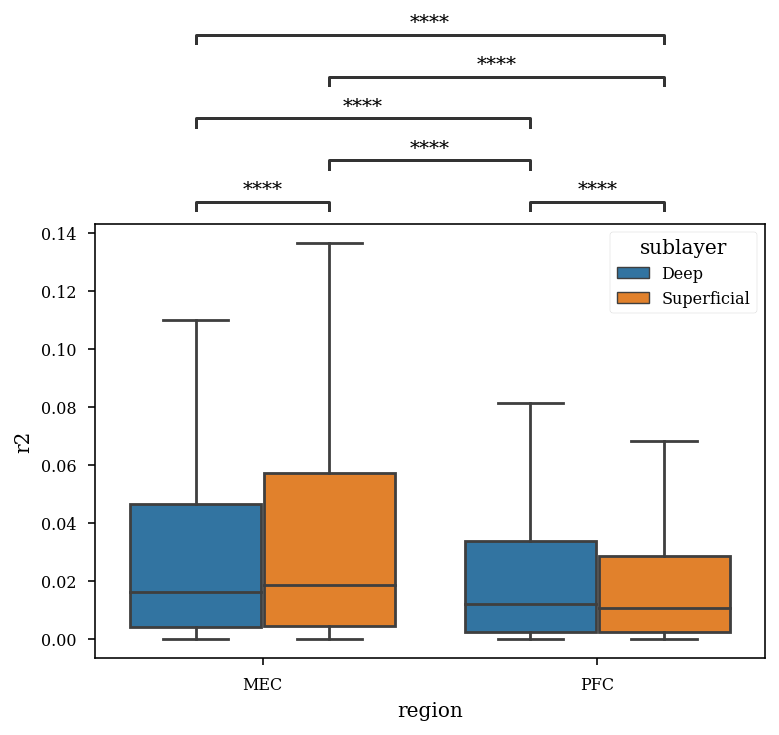

In [84]:
pre_df = pairwise_corr_df[pairwise_corr_df.epoch == "pre"]

sns.boxplot(
    x="region",
    y="r2",
    hue="sublayer",
    data=pre_df,
    showfliers=False,
)
# plt.yscale("log")
box_pairs = [
    (("MEC", "Deep"), ("MEC", "Superficial")),
    (("PFC", "Deep"), ("PFC", "Superficial")),
    (("PFC", "Deep"), ("MEC", "Deep")),
    (("PFC", "Superficial"), ("MEC", "Superficial")),
    (("PFC", "Superficial"), ("MEC", "Deep")),
    (("PFC", "Deep"), ("MEC", "Superficial")),

]
add_stat_annotation(
    plt.gca(),
    x="region",
    y="r2",
    hue="sublayer",
    data=pre_df,
    box_pairs=box_pairs,
    test="t-test_ind",
    text_format="star",
    loc="outside",
    verbose=2,
)

In [62]:
df_wide = pd.pivot(
    pairwise_corr_df, index=["basepath","region","sublayer","region_sublayer","session_idx"], columns="epoch", values=["corrcoef"]
).reset_index()
df_wide
df_wide["corrcoef_pre_post"] = (df_wide["corrcoef"]["pre"] - df_wide["corrcoef"]["post"])
df_wide["corrcoef_pre_post_abs"] = np.abs(df_wide["corrcoef_pre_post"])
df_wide["r2_pre_post"] = df_wide["corrcoef_pre_post"]**2

df_wide

basepath region sublayer region_sublayer  \
epoch                                                                 
0         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
1         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
2         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
3         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
4         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
...                             ...    ...      ...             ...   
165404  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
165405  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
165406  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
165407  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
165408  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   

       session_idx  corrcoef                     corrcoef_pre_post  \
epoch                   post       pre      task                     
0              0.0  0.115733  0.071743  0.022085         -0.043990   
1              1.0  0.063071  0.026452  0.000278         -0.036619   
2              2.0  0.086257  0.049039 -0.005033         -0.037219   
3              3.0 -0.000826  0.005640  0.015633          0.006465   
4              4.0  0.048797  0.113637 -0.015339          0.064840   
...            ...       ...       ...       ...               ...   
165404       298.0  0.228201  0.391553 -0.017103          0.163352   
165405       299.0  0.030981  0.134141  0.005404          0.103160   
165406       300.0  0.090695  0.160112  0.031985          0.069417   
165407       301.0  0.217487  0.308370  0.021767          0.090883   
165408       302.0  0.124707  0.275539  0.057264          0.150832   

       corrcoef_pre_post_abs r2_pre_post  
epoch                                     
0                   0.043990    0.001935  
1                   0.036619    0.001341  
2                   0.037219    0.001385  
3                   0.006465    0.000042  
4                   0.064840    0.004204  
...                      ...         ...  
165404              0.163352    0.026684  
165405              0.103160    0.010642  
165406              0.069417    0.004819  
165407              0.090883    0.008260  
165408              0.150832    0.022750  

[165409 rows x 11 columns]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.912e-52 U_stat=5.738e+08
MEC_Deep v.s. MEC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.522e-01 U_stat=7.121e+08


(<AxesSubplot:xlabel='region', ylabel='r2_pre_post'>,
  <statannot.StatResult.StatResult at 0x2b094df9eb0>])

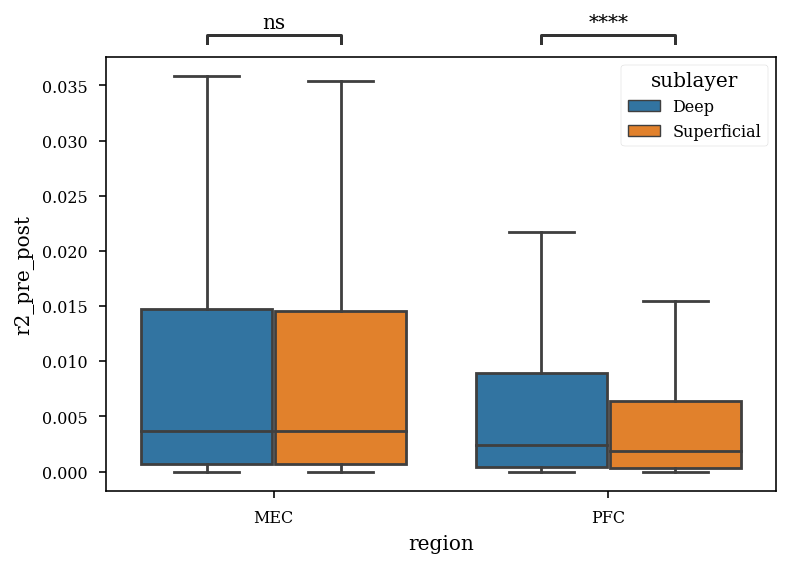

In [67]:
sns.boxplot(
    x="region",
    y="r2_pre_post",
    hue="sublayer",
    data=df_wide,
    showfliers=False,
)
# plt.yscale("log")

box_pairs = [
    (("MEC", "Deep"), ("MEC", "Superficial")),
    (("PFC", "Deep"), ("PFC", "Superficial")),
]
add_stat_annotation(
    plt.gca(),
    x="region",
    y="r2_pre_post",
    hue="sublayer",
    data=df_wide,
    box_pairs=box_pairs,
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    verbose=2,
)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Deep_MEC v.s. Superficial_MEC: t-test independent samples with Bonferroni correction, P_val=6.641e-07 stat=5.105e+00
Deep_PFC v.s. Superficial_PFC: t-test independent samples with Bonferroni correction, P_val=3.159e-42 stat=1.368e+01


(<AxesSubplot:xlabel='region_sublayer', ylabel='corrcoef_pre_post_abs'>,
  <statannot.StatResult.StatResult at 0x2b089ba91c0>])

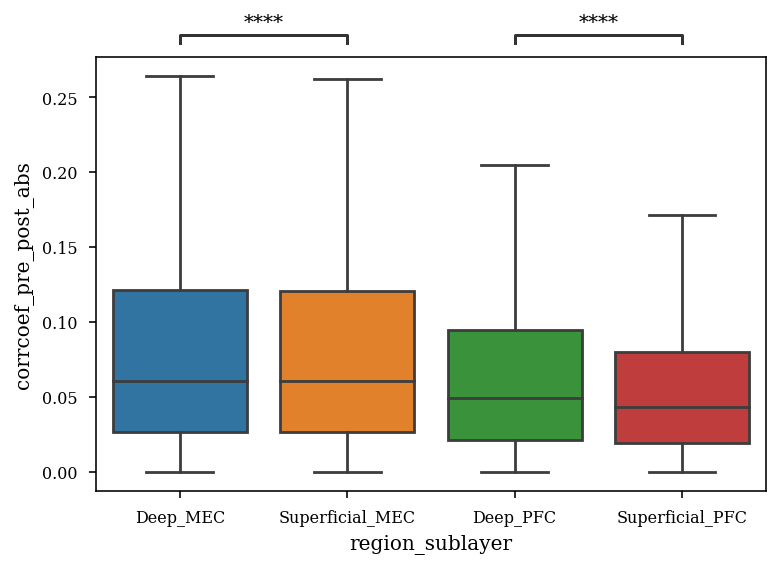

In [48]:
from statannot import add_stat_annotation

# df_wide["corrcoef_pre_post"] = (df_wide["corrcoef"]["pre"] - df_wide["corrcoef"]["post"]) / (df_wide["corrcoef"]["pre"] + df_wide["corrcoef"]["post"])


# df_wide["sup_ev_norm"] = df_wide["ev"]["Superficial"] - df_wide["rev"]["Superficial"]

sns.boxplot(x="region_sublayer", y="corrcoef_pre_post_abs", data=df_wide, showfliers=False)
# sns.stripplot(x="region_sublayer", y="corrcoef_pre_post", data=df_wide,dodge=True,color='k',alpha=.2)

box_pairs=[("Deep_MEC", "Superficial_MEC"), ("Deep_PFC", "Superficial_PFC")]
add_stat_annotation(plt.gca(),x="region_sublayer", y="corrcoef_pre_post_abs", data=df_wide,
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)